In [1]:
import os
import sys
import glob
import shutil
from copy import deepcopy
from ipywidgets import interact
import matplotlib.pyplot as plt

sys.path.append('..')
from preprocessing.ct_batch import CTImagesBatch
from dataset.dataset.dsindex import FilesIndex
print('OK')

OK


### Global index

In [2]:
DIR_TEST = '/notebooks/data/MRT/nci/*'
DIR_DUMP = '/notebooks/Koryagin/Batch_dev/dir_for_dumps/'

In [3]:
if os.path.exists(DIR_DUMP):
    shutil.rmtree(DIR_DUMP)

In [4]:
ind = FilesIndex(path=DIR_TEST, dirs=True)

### Create batch by subindexing

In [5]:
batch = CTImagesBatch(ind.create_subset(ind.index[[2,5,7]]))

In [6]:
batch.indices

array(['274a81c75d244187247789bd71de2b3a',
       '645e7f46eb9b834153ecf8e2b2921fe5',
       'd73264d2c4f71ef6bf8593ac55565d93'], 
      dtype='<U56')

### Test actions

* check load

In [7]:
batch.load(fmt='dicom')

In [8]:
batch_copy = deepcopy(batch)

* check attrs

In [9]:
batch._data.shape

(471, 512, 512)

In [10]:
batch._bounds

array([  0, 184, 314, 471])

In [11]:
batch.upper_bounds

array([184, 314, 471])

* check resize, segment, dump

In [12]:
# note that args-order is z y x, just like _data is stores in batch
batch2 = batch.resize(shape=(128, 256, 256), n_workers=6)

In [13]:
batch._data.shape

(384, 256, 256)

In [14]:
batch._bounds

array([  0, 128, 256, 384])

* check dump

In [15]:
batch2.dump(dst=DIR_DUMP)

selector_events.py[LINE:53]#DEBUG    [2017-06-01 10:25:31,465]  Using selector: EpollSelector


### Build batch from dump and compare

In [16]:
ind_dumped = FilesIndex(path=DIR_DUMP + '/*', dirs=True)

In [17]:
ind_dumped.index

array(['274a81c75d244187247789bd71de2b3a',
       '645e7f46eb9b834153ecf8e2b2921fe5',
       'd73264d2c4f71ef6bf8593ac55565d93'], 
      dtype='<U76')

In [18]:
batch_from_dump = CTImagesBatch(ind_dumped)

In [19]:
batch_from_dump.load(fmt='blosc', source=None)

In [20]:
def plot_slices(height, num_pers, *batches):
    fig, axes = plt.subplots(1, len(batches), figsize = (10, len(batches)*8))
    com_args = dict(clim=(-1200, 300), cmap=(plt.cm.gray))
    
    for i in range(len(batches)):
        axes[i].imshow(batches[i].get_axial_slice(num_pers, height), **com_args)
    
    plt.show()

In [21]:
batch.indices

array(['274a81c75d244187247789bd71de2b3a',
       '645e7f46eb9b834153ecf8e2b2921fe5',
       'd73264d2c4f71ef6bf8593ac55565d93'], 
      dtype='<U56')

In [22]:
batch_from_dump.indices

array(['274a81c75d244187247789bd71de2b3a',
       '645e7f46eb9b834153ecf8e2b2921fe5',
       'd73264d2c4f71ef6bf8593ac55565d93'], 
      dtype='<U76')

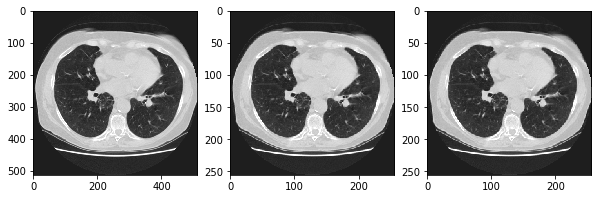

<function __main__.<lambda>>

In [23]:
interact(lambda height: plot_slices(height, 1, batch_copy, batch, batch_from_dump), 
         height=(0.01, 0.99, 0.01))

### XIP

In [24]:
xip = batch.make_xip()

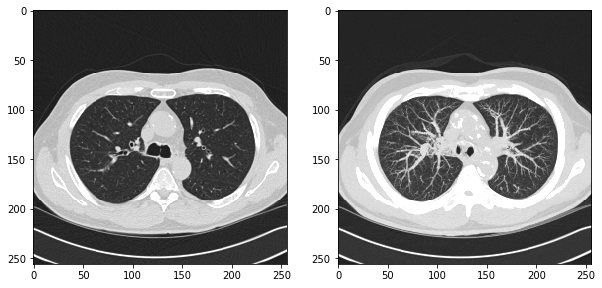

In [25]:
interact(lambda height: plot_slices(height, 2, batch_from_dump, xip), height=(0.01, 0.99, 0.01))

In [26]:
xip.indices

array(['274a81c75d244187247789bd71de2b3a',
       '645e7f46eb9b834153ecf8e2b2921fe5',
       'd73264d2c4f71ef6bf8593ac55565d93'], 
      dtype='<U56')

In [27]:
xip.index.index

array(['274a81c75d244187247789bd71de2b3a',
       '645e7f46eb9b834153ecf8e2b2921fe5',
       'd73264d2c4f71ef6bf8593ac55565d93'], 
      dtype='<U56')